In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from model.source_identify_model import SourceIdentifyModel
from model.base_intensity import ConstantBaseIntensity, SineBaseIntensity
from model.kernels import ExponentialKernel
from model.impact_function import ConstantImpactFunction
from model.mark_density import TextualMarkDensity

from collections import Counter
from sklearn.metrics import confusion_matrix, accuracy_score
import scipy.stats as stats

import seaborn as sns
sns.set_style('white')

In [2]:
# magics
%matplotlib inline
%load_ext autoreload
%autoreload 2

# Test the univariate case

In [35]:
np.random.seed(0)
n_features = 50000
feature_probs = np.random.random((1, n_features))
feature_probs /= feature_probs.sum(axis=1)[:, None]

mark_density_config = dict(
    n_features=n_features, 
    lengths=[20], 
    feature_probs=feature_probs, 
    weight=0.3
)

config = dict(
    base_intensities=[ConstantBaseIntensity()],
    base_intensity_weights=[0.05],
    influential_matrix=0.8,
    kernels=[ExponentialKernel(10)],
    impact_function=ConstantImpactFunction(),
    mark_density=TextualMarkDensity(**mark_density_config)
)

model = SourceIdentifyModel(1, **config)

In [36]:
%%time
n_max = 1000
events, parents = model.simulate(n_max, rand_state=0)
print "Generate %d events." % len(events)
print "tmax =", np.max([e[0] for e in events])

Generate 1000 events.
tmax = 4558.15441961
CPU times: user 3.08 s, sys: 8.15 ms, total: 3.08 s
Wall time: 3.09 s


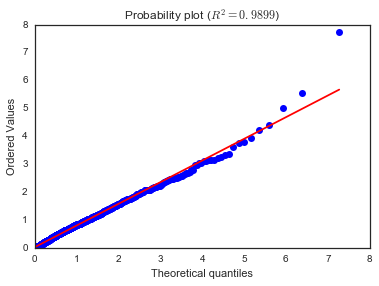

In [38]:
tau = model.cumulative_transform(events)
_, results = stats.probplot(np.diff(tau), dist='expon', plot=plt)
plt.title("Probability plot ($R^2=%1.4f$)" % results[2] ** 2)

In [32]:
timestamps = np.linspace(0, events[-1][0], 1000)
cond_intensities = model.eval_conditional_intensity(timestamps, events)
plt.plot(timestamps, cond_intensities[0])

# Test the multivate case with sine base intensity

In [3]:
np.random.seed(0)
n_dimensions = 2
dim_names = ['tweet', 'news']
n_features = 50000
feature_probs = np.random.random((n_dimensions, n_features))
feature_probs /= feature_probs.sum(axis=1)[:, None]

base_intensity1 = SineBaseIntensity(n_components=1, periods=[1000], amplitudes=[1, 0.5])
base_intensity2 = SineBaseIntensity(n_components=1, periods=[1000], amplitudes=[1, 0.5], shifts=[np.pi])

mark_density_config = dict(
    n_features=n_features, 
    lengths=[20, 300], 
    feature_probs=feature_probs, 
    weight=0.3
)

config = dict(
    base_intensities=[base_intensity1, base_intensity2],
    base_intensity_weights=[0.1, 0.1],
    influential_matrix=np.array(
                       [[0.4, 0.2], 
                        [0.2, 0.4]]),
    kernels=[ExponentialKernel(10), ExponentialKernel(50)],
    impact_function=ConstantImpactFunction(),
    mark_density=TextualMarkDensity(**mark_density_config)
)

model = SourceIdentifyModel(n_dimensions, **config)

In [4]:
%%time

events, parents = model.simulate(1000, rand_state=0)
print "Generate %r events."  % len(events)
print "tmax =", np.max([e[0] for e in events])

Generate 1000 events.
tmax = 2126.3449256
CPU times: user 4.25 s, sys: 48.6 ms, total: 4.3 s
Wall time: 4.45 s


CPU times: user 3.21 s, sys: 51.9 ms, total: 3.27 s
Wall time: 3.44 s


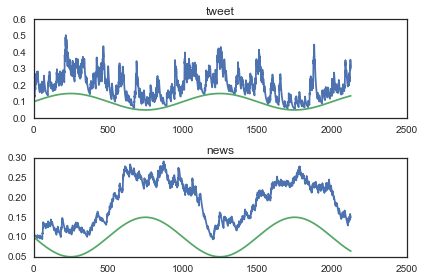

In [5]:
%%time
timestamps = np.linspace(0, events[-1][0], len(events) * 5)
cond_intensities = model.eval_conditional_intensity(timestamps, events)

for s in range(n_dimensions):
    plt.subplot(n_dimensions, 1, s + 1)
    plt.plot(timestamps, cond_intensities[s])
    plt.plot(timestamps, model.base_intensities[s].eval(timestamps) * model.base_intensity_weights[s])
    plt.title(dim_names[s])
plt.tight_layout()

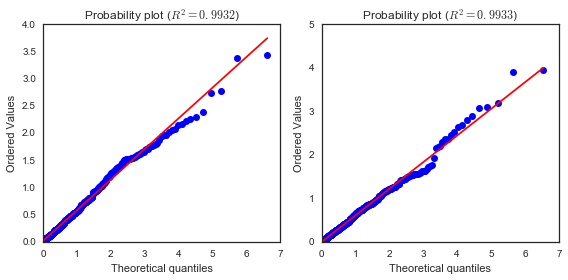

In [6]:
tau = model.cumulative_transform(events)
plt.figure(figsize=(8, 4))
for i in range(n_dimensions):
    plt.subplot(1, n_dimensions, i + 1)
    tau_i = [t for t, e in zip(tau, events) if e[1] == i]
    _, results = stats.probplot(np.diff(tau_i), dist='expon', plot=plt)
    plt.xlim(xmin=0)
    plt.ylim(ymin=0)
    plt.title("Probability plot ($R^2=%1.4f$)" % results[2] ** 2)
plt.tight_layout()

## Explore the rooted probability

In [7]:
def construct_dataframe(events, parents, roots):
    df = pd.DataFrame()
    df['timestamp'] = [e[0] for e in events]
    df['dimension'] = [e[1] for e in events]
    df['lenght'] = [e[2].sum() for e in events]
    df['parent'] = parents
    df['root'] = roots
    df.index = range(1, len(df) + 1)
    return df

In [9]:
roots = model.eval_roots((e[1] for e in events), parents)
rooted_proba = model.eval_rooted_proba(events, verbose=True)

df = construct_dataframe(events, parents, roots)
df['rp0'] = rooted_proba[:, 0]
df['rp1'] = rooted_proba[:, 1]
df['root_pred'] = np.argmax(rooted_proba, axis=1)

1000it [00:16, 61.29it/s]


Compare the predicted roots to sample roots

Confusion matrix:
[[536   2]
 [ 13 449]]


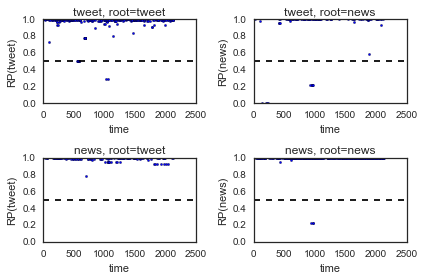

In [10]:
print "Confusion matrix:\n", confusion_matrix(df.root, df.root_pred)

dim_names = ['tweet', 'news']
for root in range(n_dimensions):
    for i in range(n_dimensions):
        t = df.query('root == %d and dimension ==%d' % (root, i))
        plt.subplot(n_dimensions, n_dimensions, i * n_dimensions + root + 1)        
        plt.scatter(t.timestamp, t['rp%d' % root], s=5)
        plt.xlim(xmin=0)
        plt.hlines(0.5, 0, plt.xlim()[1], linestyles='dashed')
        plt.ylim([0, 1])
        
        plt.ylabel('RP(%s)' % dim_names[root])
        plt.xlabel('time')
        plt.title('%s, root=%s' % (dim_names[i], dim_names[root]))

plt.gcf().suptitle('')
plt.tight_layout()

## Characteristics of wrong visits

In [11]:
print df.query('root != root_pred').groupby(['dimension', 'root']).size()
df.query('root != root_pred')

dimension  root
0          0        2
           1       10
1          1        3
dtype: int64


timestamp  dimension  lenght  parent  root       rp0       rp1  \
46    130.540009          0      21      35     1  0.998026  0.001974   
78    207.729433          0      15      39     1  0.996827  0.003173   
88    215.751182          0      23      78     1  0.996827  0.003173   
99    231.949865          0      26      88     1  0.996827  0.003173   
435   926.631923          0      13     403     1  0.777844  0.222156   
438   931.289782          1     310     435     1  0.777844  0.222156   
449   947.555291          0      23     435     1  0.777844  0.222156   
450   947.692381          0      27     449     1  0.777844  0.222156   
455   954.561854          0      17     450     1  0.777844  0.222156   
457   956.409722          0       8     450     1  0.777844  0.222156   
460   963.504185          0      20     450     1  0.777844  0.222156   
462   967.280063          1     305     460     1  0.777844  0.222156   
467   969.879585          1     282     462     1  0.777844  0.222156   
507  1036.020813          0      12       0     0  0.288932  0.711068   
535  1065.513996          0      17     507     0  0.288932  0.711068   

     root_pred  
46           0  
78           0  
88           0  
99           0  
435          0  
438          0  
449          0  
450          0  
455          0  
457          0  
460          0  
462          0  
467          0  
507          1  
535          1

In [20]:
i = 116 - 1
j = 101 - 1
ti, si, xi = events[i]
tj, sj, xj = events[j]
print events[k]
print events[l]
print np.intersect1d(xi.indices, xj.indices)
print model.mark_density.eval_log_proba_immigrant(xi, si)
print model.mark_density.eval_log_proba_offspring(xi, si, events[j])

(260.40406742898585, 1, <1x50000 sparse matrix of type '<type 'numpy.int64'>'
	with 341 stored elements in Compressed Sparse Row format>)
(193.98637904089199, 0, <1x50000 sparse matrix of type '<type 'numpy.int64'>'
	with 15 stored elements in Compressed Sparse Row format>)
[]
-2918.02987493
-3086.38044847


In [21]:
df.query('root != root_pred').groupby(['rp0', 'rp1']).size()

rp0       rp1     
0.061433  0.938567    1
0.061440  0.938560    1
          0.938560    1
0.061552  0.938448    1
0.061601  0.938399    1
0.155448  0.844552    1
0.240597  0.759403    1
0.321807  0.678193    1
          0.678193    1
          0.678193    2
0.335640  0.664360    1
0.582521  0.417479    1
0.652276  0.347724    1
          0.347724    1
          0.347724    1
          0.347724    1
          0.347724    1
0.652570  0.347430    1
          0.347430    1
0.774744  0.225256    1
0.779825  0.220175    1
0.820991  0.179009    1
0.820996  0.179004    1
0.870579  0.129421    1
          0.129421    1
0.874577  0.125423    1
0.883580  0.116420    1
          0.116420    1
0.886662  0.113338    1
0.888210  0.111790    3
          0.111790    1
0.898919  0.101081    1
          0.101081    1
0.910429  0.089571    1
0.916362  0.083638    1
0.928835  0.071165    1
0.929188  0.070812    1
0.944660  0.055340    1
0.957646  0.042354    1
0.982324  0.017676    1
          0.017676   

# Effect of mixed rate

In [4]:
np.random.seed(0)

n_dimensions = 2
dim_names = ['tweet', 'news']
t_max = 2000
base_intensities = [ConstantBaseIntensity()] * n_dimensions 
base_intensity_weights = [0.1, 0.1] 
influential_matrix = np.array(
                      [[0.4, 0.2], 
                       [0.2, 0.4]])


scale = 10
kernel = ExponentialKernel(scale)
impact_function = ConstantImpactFunction()
n_features = 50000
feature_probs = np.random.dirichlet(np.ones(n_features), 2) 
mark_density = TextualMarkDensity(n_features, lengths=[10, 500], feature_probs=feature_probs, weight=0.3)

model = SourceIdentifyModel(n_dimensions, base_intensities=base_intensities,
                            base_intensity_weights=base_intensity_weights,
                            influential_matrix=influential_matrix,
                            kernel=kernel,
                            impact_function=impact_function,
                            mark_density=mark_density)

In [24]:
weights = [.01, .05, 0.1, 0.3, 0.5, 0.7, 0.9]
df = pd.DataFrame(columns=['weight', 'run_id', 'root', 'rooted_proba'])
for weight in weights:
    print 'weight=', weight
    for run_id in range(5):
        model.mark_density.set_params(weight=weight)
        events, parents = model.simulate(t_max, rand_state=run_id)
        root = model.eval_roots([e[1] for e in events], parents)
        rooted_proba = model.eval_rooted_proba(events, verbose=True)
        df.loc[len(df)] = weight, run_id, root, rooted_proba

weight= 0.01


965it [00:21, 44.92it/s]
1026it [00:23, 43.82it/s]
1174it [00:33, 34.72it/s]
1110it [00:29, 38.21it/s]
1040it [00:26, 38.93it/s]


weight= 0.05


1022it [00:24, 42.26it/s]
1052it [00:26, 59.86it/s]
1070it [00:26, 40.00it/s]
962it [00:21, 45.03it/s]
979it [00:22, 48.36it/s]


weight= 0.1


955it [00:21, 44.72it/s]
1028it [00:25, 43.12it/s]
993it [00:22, 45.09it/s]
947it [00:20, 45.75it/s]
936it [00:20, 46.19it/s]


weight= 0.3


990it [00:22, 44.44it/s]
902it [00:18, 49.07it/s]
1010it [00:24, 41.71it/s]
969it [00:22, 43.70it/s]
955it [00:20, 45.60it/s]


weight= 0.5


904it [00:18, 48.82it/s]
991it [00:21, 45.06it/s]
998it [00:22, 44.36it/s]
950it [00:20, 47.13it/s]
980it [00:21, 44.98it/s]


weight= 0.7


960it [00:20, 46.74it/s]
1000it [00:22, 45.11it/s]
904it [00:17, 50.33it/s]
937it [00:19, 47.75it/s]
1016it [00:24, 41.76it/s]


weight= 0.9


918it [00:18, 49.44it/s]
820it [00:14, 55.45it/s]
932it [00:19, 48.90it/s]
806it [00:14, 55.33it/s]
920it [00:18, 50.20it/s]


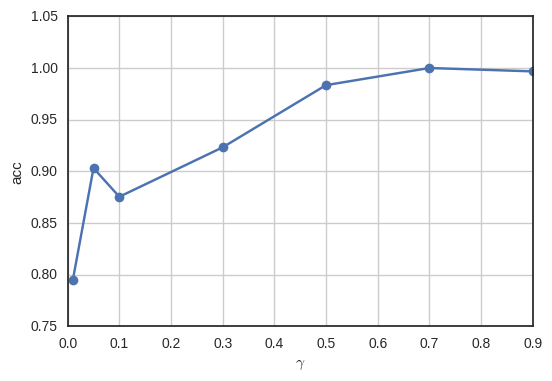

In [18]:
accs = [accuracy_score(root, np.argmax(rooted_proba, axis=1))  for root, rooted_proba in zip(roots, rooted_probas)]
plt.plot(weights, accs, 'o-')
plt.grid(True)
plt.xlabel('$\gamma$')
plt.ylabel('acc')

In [21]:
for weight, root, rooted_proba in zip(weights, roots, rooted_probas):
    print "mix rate=", weight
    print confusion_matrix(root, np.argmax(rooted_proba, axis=1))

mix rate= 0.01
[[452  31]
 [167 315]]
mix rate= 0.05
[[579  11]
 [ 88 344]]
mix rate= 0.1
[[441  12]
 [107 395]]
mix rate= 0.3
[[454  12]
 [ 64 460]]
mix rate= 0.5
[[442   4]
 [ 11 447]]
mix rate= 0.7
[[526   0]
 [  0 434]]
mix rate= 0.9
[[440   0]
 [  3 475]]
